In [ ]:
import numpy as np
import pandas as pd
# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GRU, Bidirectional, SpatialDropout1D, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Загрузка датасетов из облака google
import gdown

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras import utils              # Утилиты для подготовки данных

# Отрисовка графиков
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

#для сохраниения весов
import joblib as job

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

/home/jupyter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import os
os.getcwd()

'/home/jupyter/work/resources'

In [ ]:
# распаковываем архив и копируем в директорию
data = pd.read_csv('data.csv')

In [ ]:
#print(list(data.columns.values))

In [ ]:
#гиперпараметры
interval = 21
NAME_LIST = ['CPU', 'Memory', 'Disk']
server_list = ['serv_1', 'serv_2', 'serv_3', 'serv_4']
server = server_list[0]
metric_list = {'CPU':f'cpu_{server}',
               'Memory':f'memory_{server}',
              'Disk':f'disk_{server}'}
#NAME, server надо задать вручную
NAME = NAME_LIST[0]
metric = metric_list[NAME]


In [ ]:
print(f'NAME:{NAME}', f'server:{server}', f'metric:{metric}', sep='\n')

NAME:CPU
server:fs17
metric:cpu_windows_cpu_time_total_fs17idle_mean_diff_outliers_removed_norm


In [ ]:
data['time'] = pd.to_datetime(data['time'])
data.dtypes
data = data.set_index('time')

In [ ]:
form_data = data.copy()

In [ ]:
data.shape

(4260, 53)

In [ ]:
sp = list(form_data.columns.values)
cp_l = []
memory_l = []
disk_l = []
serv = []
for i in sp:
    if 'cpu' in i:
        cp_l.append(i)
    if 'memory' in i:
        memory_l.append(i)
    if 'disk' in i:
        disk_l.append(i)
    if 'service' in i:
        serv.append(i)
print(f'serv shape: {len(serv)}')
print(f'cpu shape: {len(cp_l)}')
print(f'memory shape: {len(memory_l)}')
print(f'disk shape: {len(disk_l)}')

serv shape: 18
cpu shape: 16
memory shape: 5
disk shape: 14


In [ ]:
def mape( actual , pred ):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))* 100

In [ ]:
def select_data(data):

    # copy current data
    form_data = data.copy()
    #check the shape
    print(f"Data's shape:{data.shape}")
    sp = list(form_data.columns.values)
    cp_l = []
    memory_l = []
    disk_l = []
    serv = []
    for i in sp:
        if 'cpu' in i:
            cp_l.append(i)
        if 'memory' in i:
            memory_l.append(i)
        if 'disk' in i:
            disk_l.append(i)
        if 'service' in i:
            serv.append(i)
    return cp_l, memory_l, disk_l, serv

In [ ]:
def drop_NaN(data, point, method = 'prob'):

  # prob - это вероятностный метод, overload - другой
    list1 = cp_l + serv
    list2 = memory_l + serv
    list3 = disk_l + serv

    sp = {'CPU':list1, 'Memory':list2, 'Disk':list3}
    list = sp[point]

    if method == 'prob':
  # заменим NaN на наиболее вероятностные значения из столбца
        for col in range(len(list)):
            mask = data[list[col]].isna()
  # считаем статистику распределения значений
            p = data[list[col]].value_counts() / len(data[list[col]].dropna())
  # заполняем пропуски с вероятностью `p`
            data.loc[mask, list[col]] = np.random.choice(p.index.to_list(),
                     size=mask.sum(),
                     p=p.to_list())
    else:
    # заменим NaN на перегрузку (интервал от 75-100)
        for col in range(len(list)):
            mask = data[list[col]].isna()
  # считаем статистику распределения значений
            p = data[list[col]].value_counts() / len(data[list[col]].dropna())
  # заполняем пропуски с вероятностью `p`
            data.loc[mask, list[col]] = np.random.choice(np.random.uniform(75, 100, size=(len(p),)),
                     size=mask.sum(),
                     p=p.to_list())

    return data

In [ ]:
def add_new_col(data, ohe_week = False, ohe_hours = False):
    # методом выбираем способ обработки дней недели: ohe, other

# for i in range(1, 22): #данные за 3 недели
#      data.loc[:,f'{i}_day_later'] = data.loc[:,'cpu'].shift(-(i*24)) #multiply
    # добавляем колонку бинарную (0 - выходной, 1 - будний день)
    data['Work/Weekend'] = data.index.weekday
    data['Work/Weekend'] = data['Work/Weekend'].apply(lambda x: 0 if (x == 5 or x == 6) else 1) #5 или 6, так как нумерация дней недели проводится от 0 до 6
    # колонка с месяцами
    #data['Month_Number'] = data.index.month
    if ohe_week:
        # Преобразование дней недели в формат one_hot_encoding
        CLASS_COUNT = 7
        col_w = pd.DataFrame(utils.to_categorical(data.index.weekday, CLASS_COUNT), columns=['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun'])
        col_w.index = data.index
        data = pd.concat([data, col_w], axis=1)
    if ohe_hours:
        # Преобразование часов в формат one_hot_encoding
        NUMB = 24
        col_h = pd.DataFrame(utils.to_categorical(data.index.hour, NUMB), columns=['24', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])
        col_h.index = data.index
        data = pd.concat([data, col_h], axis=1)
    return data

In [ ]:
def creat_dataset(data, POINT, OHE = False, OTHER = False):

    filter = [memory_l + disk_l, cp_l + disk_l, cp_l + memory_l]



    if POINT == 'CPU':
        data = data.drop(filter[0], axis = 1)
        data = add_new_col(data, OHE, OTHER)
        data = drop_NaN(data, POINT)
    if POINT == 'Memory':
        data = data.drop(filter[1], axis = 1)
        data = add_new_col(data, OHE, OTHER)
        data = drop_NaN(data, POINT)
    if POINT == 'Disk':
        data = data.drop(filter[2], axis = 1)
        data = add_new_col(data, OHE, OTHER)
        data = drop_NaN(data, POINT)
    return data

In [ ]:
data = creat_dataset(data, NAME, True, True)

In [ ]:
x_ = data.loc[data.index[:data.shape[0]-interval], :]
y_ = data.loc[data.index[interval:], metric]
print(x_.shape)
print(y_.shape)

(4239, 66)
(4239,)


In [ ]:
# разбиваем весь датасет на тренировочную и тестовую выборку
test_size = 0.15
test_index = int(len(data)*(1-test_size))
x_train = x_[:test_index]
y_train = y_[:test_index]
x_test = x_[test_index:]
y_test = y_[test_index:]


In [ ]:
#временная ось абсцисс для графика
x = list(y_test.index)
x = np.array(x)

In [ ]:
#разбиваю даты на батчи
x_train, y_train, x_test, y_test = x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d")
print("Current Time =", current_time)


Current Time = 2023-08-07


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [ ]:

# create regressor object
regressor = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs = -1, oob_score = True)

# fit the regressor with x and y data
regressor.fit(x_train, y_train)
y_pred_1 = regressor.predict(x_test)



In [ ]:
# Сохранение весов модели
#job.dump(regressor, f'weights/{NAME}_model_RF_{server}_{current_time}_StandartScalerweights.pkl')

# Загрузка весов модели
#loaded_model = joblib.load('model_RF_weights.pkl')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred_1)
mae = mean_absolute_error(y_test, y_pred_1)
#r2 = r2_score(y_test, y_pred_1)

print('Mean Squared Error (MSE): {}'.format(mse), 'Mean Absolute Error (MAE): {0:0.4f}'.format(mae), sep='\n')


Mean Squared Error (MSE): 0.0009203644460749695
Mean Absolute Error (MAE): 0.0206


In [ ]:
MAPE = mape(y_test , y_pred_1)
#print('Mean Absolute Percent Error (MAPE): {0:0.4f}%'.format(MAPE))

Mean Absolute Percent Error (MAPE): 2.1609%


In [ ]:
with open('example.txt', 'a') as f:
  #  f.write('Min_Max_scaler')
    f.write(f'\n \n server name:{server}, metric name:{NAME}_RF ')
    f.write('Mean Squared Error (MSE): {} '.format(mse))#, ,
    f.write('Mean Absolute Error (MAE): {0:0.4f} '.format(mae))
    f.write('Mean Absolute Percent Error (MAPE): {0:0.4f}% \n'.format(MAPE))


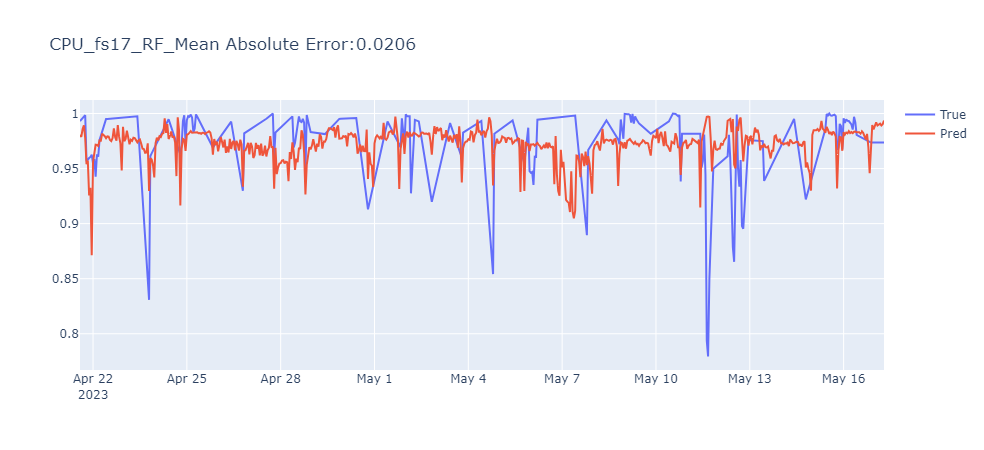

In [ ]:
#memory + ohe + выходной рабочий
TITLE = f'{NAME}_{server}_RF_Mean Absolute Error:{round(mae, 4)}'
#x = np.arange(0, 600)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = y_test, name = 'True'))
fig.add_trace(go.Scatter(x = x, y = y_pred_1, name = 'Pred'))
fig.update_layout(title = TITLE)
fig.show()
#import plotly.graph_objects as go

fig.write_html(f"sample/{NAME}/{TITLE}_{current_time}.html") # save as test.html
#help(go.Figure.write_html)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [ ]:
model = lgb.LGBMModel(objective="regression_l2", is_unbalance = True, n_estimators = 1000, n_jobs = -1, max_depth = 9, learning_rate = 0.01,
                      num_leaves = 7)

# fit the model on the whole dataset
model.fit(x_train, y_train)
pred_2 = model.predict(x_test)


In [ ]:
# Сохранение весов модели
#job.dump(model, f'weights/{NAME}_model_GBM_{server}_{current_time}weights.pkl')

# Загрузка весов модели
#loaded_model = joblib.load('Memory_model_GBM_weights.pkl')

['weights/Memory_model_GBM_fs17_2023-08-02_StandartScalerweights.pkl']

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# explained_variance_score (функция оценки регрессии дисперсии.Наилучший возможный результат равен 1.0, меньшие значения хуже.)
mse = mean_squared_error(y_test, pred_2)
mae = mean_absolute_error(y_test, pred_2)

print('Mean Squared Error (MSE): {0:0.4f}'.format(mse), 'Mean Absolute Error (MAE): {0:0.4f}'.format(mae),  sep = '\n')
#print('Explained Variance Score:',explained_variance_score(y_test, pred_2))

Mean Squared Error (MSE): 0.0008
Mean Absolute Error (MAE): 0.0186


In [ ]:
with open('example.txt', 'a') as f:
    f.write(f'server name:{server}, metric name:{NAME}_RF ')
    f.write('Mean Squared Error (MSE): {} '.format(mse))#, ,
    f.write('Mean Absolute Error (MAE): {0:0.4f} '.format(mae))
    f.write('Mean Absolute Percent Error (MAPE): {0:0.4f}% \n'.format(MAPE))


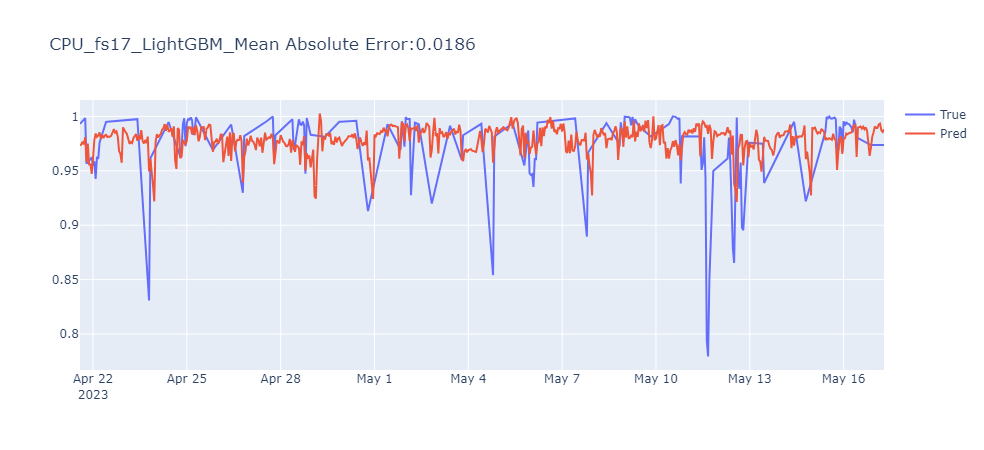

In [ ]:
#name+ohe + вых/раб
TITLE = f'{NAME}_{server}_LightGBM_Mean Absolute Error:{round(mae, 4)}'
#x = np.arange(0, 600)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = y_test, name = 'True'))
fig.add_trace(go.Scatter(x = x, y = pred_2, name = 'Pred'))
fig.update_layout(title = TITLE)
fig.show()
#import plotly.graph_objects as go

fig.write_html(f"sample/{NAME}/{TITLE}_{current_time}.html") # save as test.html
#help(go.Figure.write_html)

In [ ]:
import xgboost
from xgboost import XGBRegressor

In [ ]:
import xgboost
from xgboost import XGBRegressor
model_2 = XGBRegressor()
model_2 = XGBRegressor(n_estimators=5000, max_depth=500, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_2.fit(x_train, y_train)
pred_3 = model_2.predict(x_test)

In [ ]:
# Сохранение весов модели
#job.dump(model_2, f'weights/{NAME}_model_XG_{server}_{current_time}_StandartScalerweights.pkl')

# Загрузка весов модели
#loaded_model = joblib.load('Memory_model_XG_weights.pkl')

['weights/Memory_model_XG_fs17_2023-08-02_StandartScalerweights.pkl']

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# explained_variance_score (функция оценки регрессии дисперсии.Наилучший возможный результат равен 1.0, меньшие значения хуже.)
mse = mean_squared_error(y_test, pred_3)
mae = mean_absolute_error(y_test, pred_3)

print('Mean Squared Error (MSE): {0:0.4f}'.format(mse), 'Mean Absolute Error (MAE): {0:0.4f}'.format(mae), sep = '\n')
#print('Explained Variance Score:',explained_variance_score(y_test, pred_3))

Mean Squared Error (MSE): 0.0011
Mean Absolute Error (MAE): 0.0229


In [ ]:
with open('example.txt', 'a') as f:
    f.write(f'server name:{server}, metric name:{NAME}_RF ')
    f.write('Mean Squared Error (MSE): {} '.format(mse))#, ,
    f.write('Mean Absolute Error (MAE): {0:0.4f} '.format(mae))
    f.write('Mean Absolute Percent Error (MAPE): {0:0.4f}% \n'.format(MAPE))


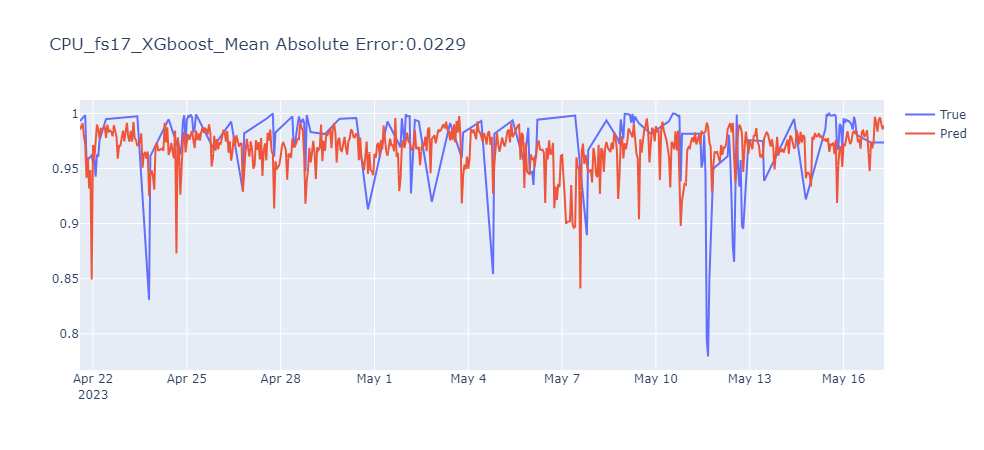

In [ ]:
#name+ohe + week/work
TITLE = f'{NAME}_{server}_XGboost_Mean Absolute Error:{round(mae, 4)}'
#x = np.arange(0, 600)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = y_test, name = 'True'))
fig.add_trace(go.Scatter(x = x, y = pred_3, name = 'Pred'))
fig.update_layout(title = TITLE)
fig.show()
#import plotly.graph_objects as go

fig.write_html(f"sample/{NAME}/{TITLE}_{current_time}.html") # save as test.html
#help(go.Figure.write_html)